In [171]:
import gc
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

train = pd.read_csv('train.csv')
train_seq_all = pd.read_csv('1d_cnn_train.csv')
train_seq_all = train_seq_all.drop(columns='Unnamed: 0')

In [182]:
train_seq_all.columns
features = train_seq_all.drop(columns=['start_month', 'cfips', 'state', 'population_average']).columns.tolist()
features

['0_0',
 '1_0',
 '2_0',
 '3_0',
 '4_0',
 '5_0',
 '6_0',
 '7_0',
 '8_0',
 '9_0',
 '10_0',
 '11_0',
 '12_0',
 '13_0',
 '14_0',
 '15_0',
 '16_0',
 '17_0',
 '18_0',
 '19_0',
 '20_0',
 '21_0',
 '22_0',
 '23_0',
 'target',
 '0_1',
 '1_1',
 '2_1',
 '3_1',
 '4_1',
 '5_1',
 '6_1',
 '7_1',
 '8_1',
 '9_1',
 '10_1',
 '11_1',
 '12_1',
 '13_1',
 '14_1',
 '15_1',
 '16_1',
 '17_1',
 '18_1',
 '19_1',
 '20_1',
 '21_1',
 '22_1',
 '23_1',
 '24_1',
 '0_2',
 '1_2',
 '2_2',
 '3_2',
 '4_2',
 '5_2',
 '6_2',
 '7_2',
 '8_2',
 '9_2',
 '10_2',
 '11_2',
 '12_2',
 '13_2',
 '14_2',
 '15_2',
 '16_2',
 '17_2',
 '18_2',
 '19_2',
 '20_2',
 '21_2',
 '22_2',
 '23_2',
 '24_2',
 '0_3',
 '1_3',
 '2_3',
 '3_3',
 '4_3',
 '5_3',
 '6_3',
 '7_3',
 '8_3',
 '9_3',
 '10_3',
 '11_3',
 '12_3',
 '13_3',
 '14_3',
 '15_3',
 '16_3',
 '17_3',
 '18_3',
 '19_3',
 '20_3',
 '21_3',
 '22_3',
 '23_3',
 '24_3',
 '0_4',
 '1_4',
 '2_4',
 '3_4',
 '4_4',
 '5_4',
 '6_4',
 '7_4',
 '8_4',
 '9_4',
 '10_4',
 '11_4',
 '12_4',
 '13_4',
 '14_4',
 '15_4',
 '16

In [173]:
def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [174]:
# get the cfips ranked by population
cfips_population_decending = train_seq_all.groupby(['cfips'])['population_average'].mean().sort_values(ascending=False).reset_index().cfips
# we use the top 50% cfips to train LSTM
cfips_LSTM = cfips_population_decending[0: int(3135/2)]

# get train data for LSTM. we only use BIG population cfips
train_seq_LSTM = train_seq_all.loc[train_seq_all['cfips'].isin(cfips_LSTM), :]

# get the cfips not used for LSTM TRAINING
cfips_not_used = list(set(train.cfips.unique()).difference(cfips_LSTM))

# print
print(f'There are {len(cfips_LSTM)} county used for LSTM training, {len(cfips_not_used)} for last value filling, total county is {len(cfips_LSTM)+len(cfips_not_used)}.')

There are 1567 county used for LSTM training, 1568 for last value filling, total county is 3135.


Learning rate schedule: 0.001 to 0.001 to 1e-06


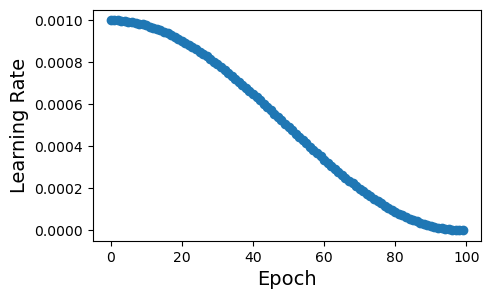

In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

VERBOSE = 0
PATH_TO_MODEL = './'
EPOCHS = 100            # 70
BATCH_SIZE = 128       # 100

SEED = 602

LR_MAX = 1e-3         # 1e-3
LR_MIN = 1e-6         # 1e-6

def causal_padding(x, kernel_size):
    pad = (kernel_size - 1)
    return torch.nn.functional.pad(x, (pad, 0))


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=6, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.batchnorm = nn.BatchNorm1d(64)  # Add batch normalization layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Add dropout layer
        self.gru = nn.GRU(input_size=64, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = causal_padding(x, kernel_size=3)
        x = self.conv1d(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # Transpose the dimensions
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        return x
def lrfn(epoch_i, EPOCHS):
    decay_total_epochs = EPOCHS - 1
    phase = math.pi * epoch_i / decay_total_epochs  # 0 ~ pi
    cosine_decay = 0.5 * (1 + math.cos(phase))
    lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x, EPOCHS) for x in rng]
plt.figure(figsize=(5, 3))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel('Epoch', size=14)
plt.ylabel('Learning Rate', size=14)
plt.show()

In [181]:
n_row = train_seq_LSTM[features].shape[0]
reshaped = train_seq_LSTM[features].values.reshape(n_row, 6, 25)
x = torch.tensor(reshaped, dtype=torch.float32)
y = torch.tensor(train_seq_LSTM.loc[:, 'target'].values, dtype=torch.float32)
groups = np.array(train_seq_LSTM.loc[:, 'cfips'])
print(f'{x.shape}, {y.shape}, {groups.shape}')

torch.Size([17237, 6, 25]), torch.Size([17237]), (17237,)


In [146]:
import os
import numpy as np
from sklearn.model_selection import GroupKFold
import torch
from torch.utils.data import DataLoader, TensorDataset

gkf = GroupKFold(n_splits=5)

validation_pred_y_all = []  # predictions of the validation data for all the folds
validation_y_all = []       # corresponding labels of the validation data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold = 0
for train_idx, validation_idx in gkf.split(x, y, groups=groups):
    
    print(f'------------------- FOLD{fold} -------------------')
    
    train_x = x[train_idx, :]
    train_y = y[train_idx]
    validation_x = x[validation_idx, :]
    validation_y = y[validation_idx]

    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    validation_dataset = TensorDataset(validation_x, validation_y)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output.squeeze(), batch_y)
                val_loss += loss.item()

        val_loss /= len(validation_loader)
        val_losses.append(val_loss)

        lr = lrfn(epoch, EPOCHS)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    torch.save(model.state_dict(), f'{PATH_TO_MODEL}GRU_fold_{fold+1}.pt')

    # Plot train and validation loss
    plt.figure(num=1, figsize=(25, 5))
    plt.subplot(1, 5, fold+1)
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')

    model.eval()
    validation_pred_y = []
    with torch.no_grad():
        for batch_x, batch_y in validation_loader:
            batch_x = batch_x.to(device)
            output = model(batch_x)
            validation_pred_y.extend(output.squeeze().cpu().numpy())
    validation_pred_y = np.array(validation_pred_y)

    smape_1_fold = smape(validation_y.numpy(), validation_pred_y)
    trained_epoch_num = len(train_losses)
    print(f'Fold {fold} validation smape is {smape_1_fold}, trained with {trained_epoch_num} epochs.')

    validation_pred_y_all.append(validation_pred_y)
    validation_y_all.append(validation_y.numpy())

    fold += 1

plt.show()

validation_pred_y_all


------------------- FOLD0 -------------------


RuntimeError: input.size(-1) must be equal to input_size. Expected 32, got 64